# Filter theory

The theory behind `gcm-filters` is described here at a high level.
For a more detailed treatment, see [Grooms et al. (2021)](https://doi.org/10.1002/essoar.10506591.1).

## Filter Scale and Shape

Any low-pass spatial filter should have a target length scale such that the filtered field keeps the part of the signal with length scales larger than the target length scale, and smoothes out smaller scales. In the context of this package the target length scale is called `filter_scale`.

A spatial filter can also have a *shape* that determines how sharply it separates scales above and below the target length scale.
The filter shape can be thought of in terms of the kernel of a convolution filter
\(
\bar{f} = \int G(x - x')f(x') dx',
\)
where $f$ is the function being filtered, $G$ is the filter kernel, and $x'$ is a dummy integration variable.
This package currently has two filter shapes to choose from: `GAUSSIAN` and `TAPER`.

In [2]:
import gcm_filters
list(gcm_filters.FilterShape)

[<FilterShape.GAUSSIAN: 1>, <FilterShape.TAPER: 2>]

For the `GAUSSIAN` filter the `filter_scale` equals $\sqrt{12}\,\times$ the standard deviation of the Gaussian. I.e. if you want to use a `GAUSSIAN` filter with standard deviation L, then you should set `filter_scale` equal to L $\times\sqrt{12}$. This strange-seeming choice makes the Gaussian kernel have the same effect on large scales as a boxcar filter of width `filter_scale`. Thus `filter_scale` can be thought of as the "coarse grid scale" of the filtered field. 

We can create a Gaussian filter as follows.

In [3]:
gaussian_filter = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)
gaussian_filter

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=5, grid_type=<GridType.REGULAR: 1>)

Once the filter has been constructed, the method `plot_shape` can be used to plot the shape of the target filter and the approximate filter.

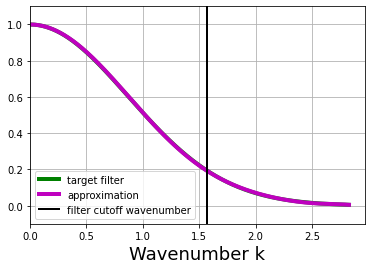

In [4]:
gaussian_filter.plot_shape()

`plot_shape` does not plot the shape of the filter *kernel*. Instead, it plots the frequency response of the filter for each wavenumber $k$. In other words, the plot shows how the filter attenuates different scales in the data. Length scales are related to wavenumbers by $l=2\pi/k$. The filter leaves large scales unchanged, so the plot shows values close to 1 for small $k$. The filter damps out small scales, so the plots shows values close to 0 for large $k$.

The definition of the `TAPER` filter is more complex, but the `filter_scale` has the same meaning: it corresponds to the width of a qualitatively-similar boxcar filter.

In [5]:
taper_filter = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)
taper_filter

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=16, grid_type=<GridType.REGULAR: 1>)

The `TAPER` filter is more scale-selective than the Gaussian filter; it does a better job of leaving scales larger than the filter scale unchanged, and removing scales smaller than the filter scale.

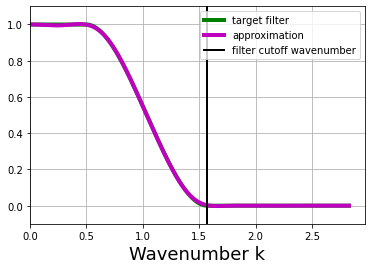

In [6]:
taper_filter.plot_shape()

The drawbacks of the `TAPER` filter are that it requires higher computational cost for the same filter scale (due to a higher number of necessary filter steps, see below), and it can produce negative values for the filtered field even when the unfiltered field is positive.

The `TAPER` filter has a tunable parameter `transition_width` that controls how sharply the filter separates scales above and below the filter scale.
`transition_width` = 1 would be the same as a complete *projection* onto the large scales, leaving the small scales completely zeroed out.
This would require a very high computational cost, and is not at all recommended!
The default is `transition_width` = $\pi$.
Larger values for `transition_width` reduce the cost and the likelihood of producing negative values from positive data, but make the filter less scale-selective. In the example below, we choose `transition_width` = $2\pi$.

In [7]:
import numpy as np

wider_taper_filter = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    transition_width=2*np.pi,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)
wider_taper_filter

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=6.283185307179586, ndim=2, n_steps=16, grid_type=<GridType.REGULAR: 1>)

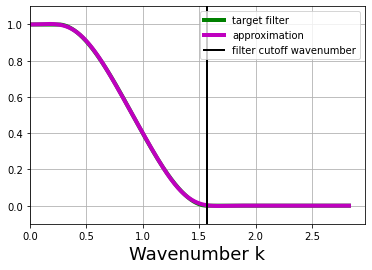

In [8]:
wider_taper_filter.plot_shape()

## Filter Steps

The filter goes through several steps to produce the final filtered field. There are two different kinds of steps: "Laplacian" and "Biharmonic" steps. At each Laplacian step, the filtered field is updated using the following formula

\begin{equation}
\bar{f} \leftarrow \bar{f} + \frac{1}{s_{j}}\Delta \bar{f}
\end{equation}

The filtered field is initialized to $\bar{f}=f$ and $\Delta$ denotes a discrete Laplacian. At each Biharmonic step, the filtered field is updated using

\begin{equation}
\bar{f}\leftarrow \bar{f}+\frac{2R\{s_j\}}{|s_j|^2}\Delta\bar{f} + \frac{1}{|s_j|^2}\Delta^2\bar{f}
\end{equation}

where $R\{\cdot\}$ denotes the real part of a complex number.

The total number of steps, `n_steps`, and the values of $s_j$ are automatically selected by the code to produce the desired filter scale and shape. If the filter scale is much larger than the grid scale, many steps are required. 
Also, the Taper filter requires more steps than the Gaussian filter for the same `filter_scale`; in the above examples the Taper filters required `n_steps = 16`, but the Gaussian filter only `n_steps = 5`.

The code allows users to set their own `n_steps`. Biharmonic steps are counted as 2 steps because their cost is approximately twice as much as a Laplacian step. So with `n_steps` = 3 you might get one Laplacian plus one biharmonic step, or three Laplacian steps. (The user cannot choose how `n_steps` is split between Laplacian and Biharmonic steps; that split is set internally in the code.) 

For example, the user might want to use a smaller number of steps to reduce the cost. The caveat is that the accuracy will be reduced, so the filter might not act as expected: it may not have the right shape or the right length scale. To illustrate this, we create a new filter with a smaller number of steps than the default `n_steps = 16`, and plot the result. (Note that using a value of `n_steps` lower than the default will raise a warning.)

In [12]:
taper_filter_8steps = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=8,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)
taper_filter_8steps

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:11: UserWarning: You have set n_steps below the default. Results might not be accurate.
  


Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=8, grid_type=<GridType.REGULAR: 1>)

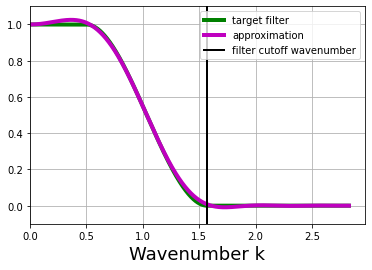

In [13]:
taper_filter_8steps.plot_shape()

The example above shows that using `n_steps = 8` still yields a very accurate approximation of the target filter, at half the cost of the default. The main drawback in this example is that the filter slightly *amplifies* large scales, which also implies that it will not conserve variance. 

The example below shows what happens with `n_steps = 4`.

In [14]:
taper_filter_4steps = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=4,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)
taper_filter_4steps

/glade/u/home/noraloose/gcm-filters/gcm_filters/filter.py:11: UserWarning: You have set n_steps below the default. Results might not be accurate.
  


Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=4, grid_type=<GridType.REGULAR: 1>)

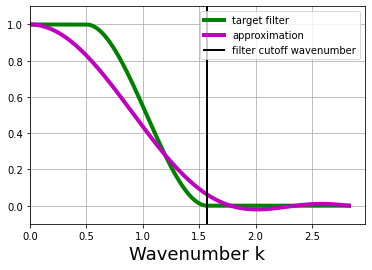

In [15]:
taper_filter_4steps.plot_shape()

For this example of a Taper filter with a filter factor of 4, `n_steps = 4` is simply not enough to get a good approximation of the target filter. The `taper_filter_4steps` object created here will still "work" but it will not behave as expected; specifically, it will smooth more than expected - it will act like a filter with a larger filter scale.
    
The minimum number of steps is 3; if `n_steps` is not set by the user, or if it is set to a value less than 3, the code automatically changes `n_steps` to the default value. 

## Numerical Stability

When `filter_scale` is much larger than the minimum grid scale, `dx_min`, the filter can become unstable to roundoff errors.
The usual manifestation of these roundoff errors is high-amplitude small-scale noise in the filtered field.
(This problem is worse for the Taper filter than the Gaussian filter.)
In such cases user has a few options to try to regain stability.

1. If the data being filtered is single-precision, it might help to promote it to double precision (or higher) before filtering.
2. The user can also try reducing `n_steps`, but must not reduce it too much or the resulting filter will not behave as expected.
3. Users might elect to *coarsen* their data before filtering, i.e. to reduce the resolution of the input data before applying the filter. This has the effect of increasing the grid size, and thus decreasing the gap between the filter scale and the minimum grid scale `dx_min`.
4. The final option is simply to use a different approach to filtering, not based on `gcm-filters`.

[Here](https://gcm-filters.readthedocs.io/en/latest/example_numerical_instability.html) is an example of numerical instability, as well as examples of avoiding the instability by increasing the precision and coarsening the data.

## Spatially-Varying Filter Scale

In the foregoing discussion the filter scale is fixed over the physical domain.
It is possible to vary the filter scale over the domain by introducing a "diffusivity" $\kappa$.
(This "diffusivity" is nondimensional.)
The Laplacian steps are altered to

\begin{equation}
\bar{f} \leftarrow \bar{f} + \frac{1}{s_{j}}\nabla\cdot(\kappa\nabla \bar{f})
\end{equation}

and the Biharmonic steps are similarly altered by replacing $\Delta$ with $\nabla\cdot(\kappa\nabla)$.
With $\kappa$, the *local* filter scale is $\sqrt{\kappa}\,\times$ `filter_scale`.
For reasons given in [Grooms et al. (2021)](https://doi.org/10.1002/essoar.10506591.1), we require $\kappa\le 1$, and at least one place in the domain where $\kappa = 1$.
Thus, when using variable $\kappa$, `filter_scale` sets the *largest* filter scale in the domain and the local filter scale can be reduced by making $\kappa<1$.

Suppose, for example, that you want the local filter scale to be $L(x,y)$.
You can achieve this in `gcm-filters` as follows.

1. Set `filter_scale` equal to the maximum of $L(x,y)$ over the domain. (Call this value $L_{max}$).
2. Set $\kappa$ equal to $L(x,y)^2/L_{max}^2$.

[Here](https://gcm-filters.readthedocs.io/en/latest/example_filter_types.html) you find some examples of filtering with spatially-varying filter scale.

## Anisotropic Filtering

It is possible to have different filter scales in different directions, and to have both the scales and directions vary over the domain.
This is achieved by replacing $\kappa$ in the previous section with a $2\times 2$ symmetric and positive definite matrix (for a 2D domain), i.e. replacing $\Delta$ with $\nabla\cdot(\mathbf{K}\nabla)$.
`gcm-filters` currently only supports diagonal $\mathbf{K}$, i.e. the principal axes of the anisotropic filter are aligned with the grid, so that the user only inputs one $\kappa$ for each grid direction, rather than a full $2\times 2$ matrix.
Just like in the previous section, we require that each of these two $\kappa$ be less than or equal to 1, and the interpretation is also the same: the local filter scale in a particular direction is $\sqrt{\kappa}\,\times$ `filter_scale`.

Suppose, for example, that you want to filter with a scale of 60 in the grid-x direction and a scale of 30 in the grid-y direction.
Then you would set `filter_scale =  60`, with $\kappa_x = 1$ to get a filter scale of 60 in the grid-x direction.
Next, to get a filter scale of 30 in the grid-y direction you would set $\kappa_y=1/4$.

[This notebook](https://gcm-filters.readthedocs.io/en/latest/example_filter_types.html) shows examples of anisotropic filtering. 

## Fixed Factor Filtering
[This notebook](https://gcm-filters.readthedocs.io/en/latest/example_filter_types.html) also shows methods designed specifically for the case where the user wants to set the local filter scale equal to a multiple of the local grid scale to achieve a fixed "coarsening" factor. This can be achieved using the anisotropic diffusion described in the previous section.

An alternative way to achieve filtering with fixed "coarsening" factor is what we refer to as **simple fixed factor filtering**. This method is somewhat ad hoc, and *not* equivalent to fixed factor filtering via anisotropic diffusion. On the upside, simple fixed factor filtering is often significantly faster and yields very similar results in practice, as seen in [this example](https://gcm-filters.readthedocs.io/en/latest/example_filter_types.html). Simple fixed factor filtering works as follows:

1. Multiply the unfiltered data by the local grid cell area.
2. Apply the filter *as if* the grid scale were uniform, i.e. tell the filter that the grid spacings are all equal to 1. In particular, `dx_min = 1`.
3. Divide the resulting field by the local grid cell area.

The first step is essentially a coordinate transformation where your original (locally orthogonal) grid is transformed to a uniform Cartesian grid with $dx = dy = 1$. The third step is the reverse coordinate transformation. These three steps are handled internally by `gcm-filters` if the user chooses one of the following grid types: `TRANSFORMED_TO_REGULAR`, `TRANSFORMED_TO_REGULAR_WITH_LAND`, `TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND`. Read more about the different grid types [here](https://gcm-filters.readthedocs.io/en/latest/basic_filtering.html).

## Filtering Vectors

In Cartesian geometry the Laplacian of a vector field can be obtained by taking the Laplacian of each component of the vector field, so vector fields can be filtered as described in the foregoing sections.
On smooth manifolds, the Laplacian of a vector field is not the same as the Laplacian of each component of the vector field.
Users may wish to use a vector Laplacian to filter vector fields.
The filter is constructed in exactly the same way; the only difference is in how the Laplacian is defined.
Rather than taking a scalar field and returning a scalar field, the vector Laplacian takes a vector field as input and returns a vector field.
To distinguish this from the scalar Laplacian, we refer to the filter based on a scalar Laplacian as a "diffusion-based" filter and the filter based on a vector Laplacian as a "viscosity-based" filter.
[This notebook](https://gcm-filters.readthedocs.io/en/latest/example_vector_laplacian.html) has examples of viscosity-based filtering.